# Customer Churn

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sn

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn import linear_model
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler,MinMaxScaler

from collections import defaultdict

pd.set_option("display.max_columns",1000)

## 1. Data Preparation
In the given dataset, Churn is the target variable and the other are predictors.

After reading the dataset and examining few records, looks like there are alternative empty rows. So, let's clean this data by removing all empty rows and duplicate records if found.

In [2]:
master_dataset = pd.read_csv("Datasets/Churn_MV.csv",)
master_dataset.head()

,Account Length,VMail Message,Day Mins,Eve Mins,Night Mins,Intl Mins,CustServ Calls,Churn,Intl Plan,VMail Plan,Day Calls,Day Charge,Daily Charges MV,Eve Calls,Eve Charge,Night Calls,Night Charge,Intl Calls,Intl Charge,State,Area Code,Phone
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,128.0,25.0,265.1,197.4,244.7,10.0,1.0,0.0,0.0,1.0,110.0,45.07,45.07,99.0,16.78,91.0,11.01,3.0,2.7,KS,415.0,382-4657
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,107.0,26.0,161.6,195.5,254.4,13.7,1.0,0.0,0.0,1.0,123.0,27.47,27.47,103.0,16.62,103.0,11.45,3.0,3.7,OH,415.0,371-7191
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 1.1 Drop Duplicates
The function fn_del_dup_rows takes a dataframe as in input and checks for any duplicate records in the dataframe. If found, the duplicate rceords are dropped by preserving only one of the records. 
Next, the if any empty rows are found, the entire rows are dropped from the dataframe. The function returns two dataframes - the original dataframe and cleaned dataframe after removing duplicates and empty records.

In [3]:
def fn_del_dup_rows(df):
    duplicated_df = df.copy()
    tot_rows = duplicated_df.shape[0]
    
    # Dropping duplicate records
    df.drop_duplicates(inplace=True)
    distinct_rows = df.shape[0]
    if(distinct_rows<tot_rows):
        print("Duplicates found. Total duplicates",tot_rows-distinct_rows)
    
    #Dropping empty records
    tot_rows = df.shape[0]
    df.dropna(axis=0, how='all',inplace=True)
    distinct_rows = df.shape[0]
    if(distinct_rows<tot_rows):
        print("Empty records found. Total empty records",tot_rows-distinct_rows)

    return duplicated_df,df

duplicated_df,master_dataset = fn_del_dup_rows(master_dataset)

Duplicates found. Total duplicates 3332
Empty records found. Total empty records 1


In [4]:
master_dataset.head()

,Account Length,VMail Message,Day Mins,Eve Mins,Night Mins,Intl Mins,CustServ Calls,Churn,Intl Plan,VMail Plan,Day Calls,Day Charge,Daily Charges MV,Eve Calls,Eve Charge,Night Calls,Night Charge,Intl Calls,Intl Charge,State,Area Code,Phone
1,128.0,25.0,265.1,197.4,244.7,10.0,1.0,0.0,0.0,1.0,110.0,45.07,45.07,99.0,16.78,91.0,11.01,3.0,2.70,KS,415.0,382-4657
3,107.0,26.0,161.6,195.5,254.4,13.7,1.0,0.0,0.0,1.0,123.0,27.47,27.47,103.0,16.62,103.0,11.45,3.0,3.70,OH,415.0,371-7191
5,137.0,0.0,243.4,121.2,162.6,12.2,0.0,0.0,0.0,0.0,114.0,41.38,41.38,110.0,10.30,104.0,7.32,5.0,3.29,NJ,415.0,358-1921
7,84.0,0.0,299.4,61.9,196.9,6.6,2.0,0.0,1.0,0.0,71.0,50.90,50.90,88.0,5.26,89.0,8.86,7.0,1.78,OH,408.0,375-9999
9,75.0,0.0,166.7,148.3,186.9,10.1,3.0,0.0,1.0,0.0,113.0,28.34,28.34,122.0,12.61,121.0,8.41,3.0,2.73,OK,415.0,330-6626


In [5]:
master_dataset.shape

(3333, 22)

The dataframe has 22 variables and 3333 records.

In [6]:
master_dataset.describe(include="all")

,Account Length,VMail Message,Day Mins,Eve Mins,Night Mins,Intl Mins,CustServ Calls,Churn,Intl Plan,VMail Plan,Day Calls,Day Charge,Daily Charges MV,Eve Calls,Eve Charge,Night Calls,Night Charge,Intl Calls,Intl Charge,State,Area Code,Phone
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3283.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333,3333.000000,3333
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51,NaN,3333
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WV,NaN,356-7511
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,106,NaN,1
mean,101.064806,8.099010,179.775098,200.980348,200.872037,10.237294,1.562856,0.144914,0.096910,0.276628,100.435644,30.562307,30.533475,100.114311,17.083540,100.107711,9.039325,4.479448,2.764581,NaN,437.182418,NaN
std,39.822106,13.688365,54.467389,50.713844,50.573847,2.791840,1.315491,0.352067,0.295879,0.447398,20.069084,9.259435,9.205538,19.922625,4.310668,19.568609,2.275873,2.461214,0.753773,NaN,42.371290,NaN
min,1.000000,0.000000,0.000000,0.000000,23.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.000000,1.040000,0.000000,0.000000,NaN,408.000000,NaN
25%,74.000000,0.000000,143.700000,166.600000,167.000000,8.500000,1.000000,0.000000,0.000000,0.000000,87.000000,24.430000,24.420000,87.000000,14.160000,87.000000,7.520000,3.000000,2.300000,NaN,408.000000,NaN
50%,101.000000,0.000000,179.400000,201.400000,201.200000,10.300000,1.000000,0.000000,0.000000,0.000000,101.000000,30.500000,30.500000,100.000000,17.120000,100.000000,9.050000,4.000000,2.780000,NaN,415.000000,NaN
75%,127.000000,20.000000,216.400000,235.300000,235.300000,12.100000,2.000000,0.000000,0.000000,1.000000,114.000000,36.790000,36.745000,114.000000,20.000000,113.000000,10.590000,6.000000,3.270000,NaN,510.000000,NaN


In [7]:
master_dataset.dtypes

Account Length      float64
VMail Message       float64
Day Mins            float64
Eve Mins            float64
Night Mins          float64
Intl Mins           float64
CustServ Calls      float64
Churn               float64
Intl Plan           float64
VMail Plan          float64
Day Calls           float64
Day Charge          float64
Daily Charges MV    float64
Eve Calls           float64
Eve Charge          float64
Night Calls         float64
Night Charge        float64
Intl Calls          float64
Intl Charge         float64
State                object
Area Code           float64
Phone                object
dtype: object

In [8]:
master_dataset.columns

Index(['Account Length', 'VMail Message', 'Day Mins', 'Eve Mins', 'Night Mins',
       'Intl Mins', 'CustServ Calls', 'Churn', 'Intl Plan', 'VMail Plan',
       'Day Calls', 'Day Charge', 'Daily Charges MV', 'Eve Calls',
       'Eve Charge', 'Night Calls', 'Night Charge', 'Intl Calls',
       'Intl Charge', 'State', 'Area Code', 'Phone'],
      dtype='object')

### 1.2 Datatype Conversion
Looks like pandas has considered almost all variables as float and 2 variables as objects. Let's assign the actual datatypes to each of the variables. 

The function get_uniq_vals takes a dataframe as an input and returns a Series of unique values in each column. This helps in identifying the categorical variables in the dataset.

The function fn_set_dtypes takes 5 parameters as inputs - the dataframe, a list of all categorical variable names, a list of integers and a list of floats and a list of objects. 

The function returns a dataframe by assigning the appropriate datatype to each variable.

In [9]:
def get_uniq_vals(df):
    uniq_vals=pd.Series()
    for col in df.columns:
        uniq_vals[col]=df[col].unique().shape[0]
    return uniq_vals
        
get_uniq_vals(master_dataset)

Account Length       212
VMail Message         46
Day Mins            1667
Eve Mins            1611
Night Mins          1591
Intl Mins            162
CustServ Calls        10
Churn                  2
Intl Plan              2
VMail Plan             2
Day Calls            119
Day Charge          1667
Daily Charges MV    1650
Eve Calls            123
Eve Charge          1440
Night Calls          120
Night Charge         933
Intl Calls            21
Intl Charge          162
State                 51
Area Code              3
Phone               3333
dtype: int64

In [10]:
def fn_set_dtypes(df,categories_,ints_,floats_,objects_):
    for category_ in categories_:
        df[category_] = df[category_].astype("category")
        
    for int_ in ints_:
        df[int_] = df[int_].astype("int64")
        
    for float_ in floats_:
        df[float_] = df[float_].astype("float64")
        
    for object_ in objects_:
        df[object_] = df[object_].astype("object")
    return df

categories_=['Churn','State', 'Area Code','Intl Plan', 'VMail Plan','CustServ Calls']
ints_=['Account Length', 'Day Calls','Eve Calls','Night Calls','Intl Calls',]
floats_=['VMail Message', 'Day Mins', 'Eve Mins', 'Night Mins',
       'Intl Mins', 'Day Charge', 'Daily Charges MV',
       'Eve Charge', 'Night Charge','Intl Charge']
objects_=['Phone']
master_dataset = fn_set_dtypes(master_dataset,categories_,ints_,floats_,objects_)
master_dataset.dtypes

Account Length         int64
VMail Message        float64
Day Mins             float64
Eve Mins             float64
Night Mins           float64
Intl Mins            float64
CustServ Calls      category
Churn               category
Intl Plan           category
VMail Plan          category
Day Calls              int64
Day Charge           float64
Daily Charges MV     float64
Eve Calls              int64
Eve Charge           float64
Night Calls            int64
Night Charge         float64
Intl Calls             int64
Intl Charge          float64
State               category
Area Code           category
Phone                 object
dtype: object

## 2. Missing Value Treatment

Let's check if any variable has missing values in the dataset and use a correct method to impute.

The function fn_get_missing_vals takes a dataframe and returns a dataframe which contains the list of all variables and number of missing values in each variable along with percentages. 

In [11]:
def fn_get_missing_vals(df,cols_):
    df=df[cols_]
    n_rows = df.shape[0]
    miss_val_cnts = df.isna().sum()
    miss_vals = pd.DataFrame(miss_val_cnts[miss_val_cnts>0],columns=['Missing Val Count'])
    miss_vals['Percentage'] = miss_vals['Missing Val Count']*100/n_rows
    return miss_vals

fn_get_missing_vals(master_dataset,categories_+ints_+floats_+objects_)

,Missing Val Count,Percentage
Daily Charges MV,50,1.50015


### 2.1.1 Handling Missing Values in Daily Charges MV

In [12]:
master_dataset.loc[:,['Day Calls', 'Day Charge', 'Daily Charges MV']].head()

,Day Calls,Day Charge,Daily Charges MV
1,110,45.07,45.07
3,123,27.47,27.47
5,114,41.38,41.38
7,71,50.90,50.90
9,113,28.34,28.34


Looks like Day Charge and Daily Charges MV variables' data is almost same based on the few records. Let's check of this is true. 

In [13]:
f = master_dataset['Day Charge']==master_dataset['Daily Charges MV']
f.groupby(f).aggregate('count')

False      50
True     3283
dtype: int64

In [14]:
f = master_dataset.loc[~master_dataset['Daily Charges MV'].isna()]
f = f['Day Charge']==f['Daily Charges MV']
f.groupby(f).aggregate('count')

True    3283
dtype: int64

Ignoring all the 50 missing values from the dataframe, the rest of 3282 records have same data for Day Charge and Daily Charges MV variables. We can either copy Day Charge value for Daily Charges MV for the 50 data points or drop the variable from the datfame. 

Let's remove the Daily Charges MV from the list of variables. 

In [15]:
floats_.remove('Daily Charges MV')

In [16]:
fn_get_missing_vals(master_dataset,categories_+ints_+floats_+objects_)

,Missing Val Count,Percentage


Looks like we've handled all missing values :)

## 3. Exploratory Data Analysis

Let's visualize data and draw some insights on the dataset and distributions.

### 3.1 Univariate Analysis

Let's visualize the data and distributions of each variable. 

#### 3.1.1 Numerical

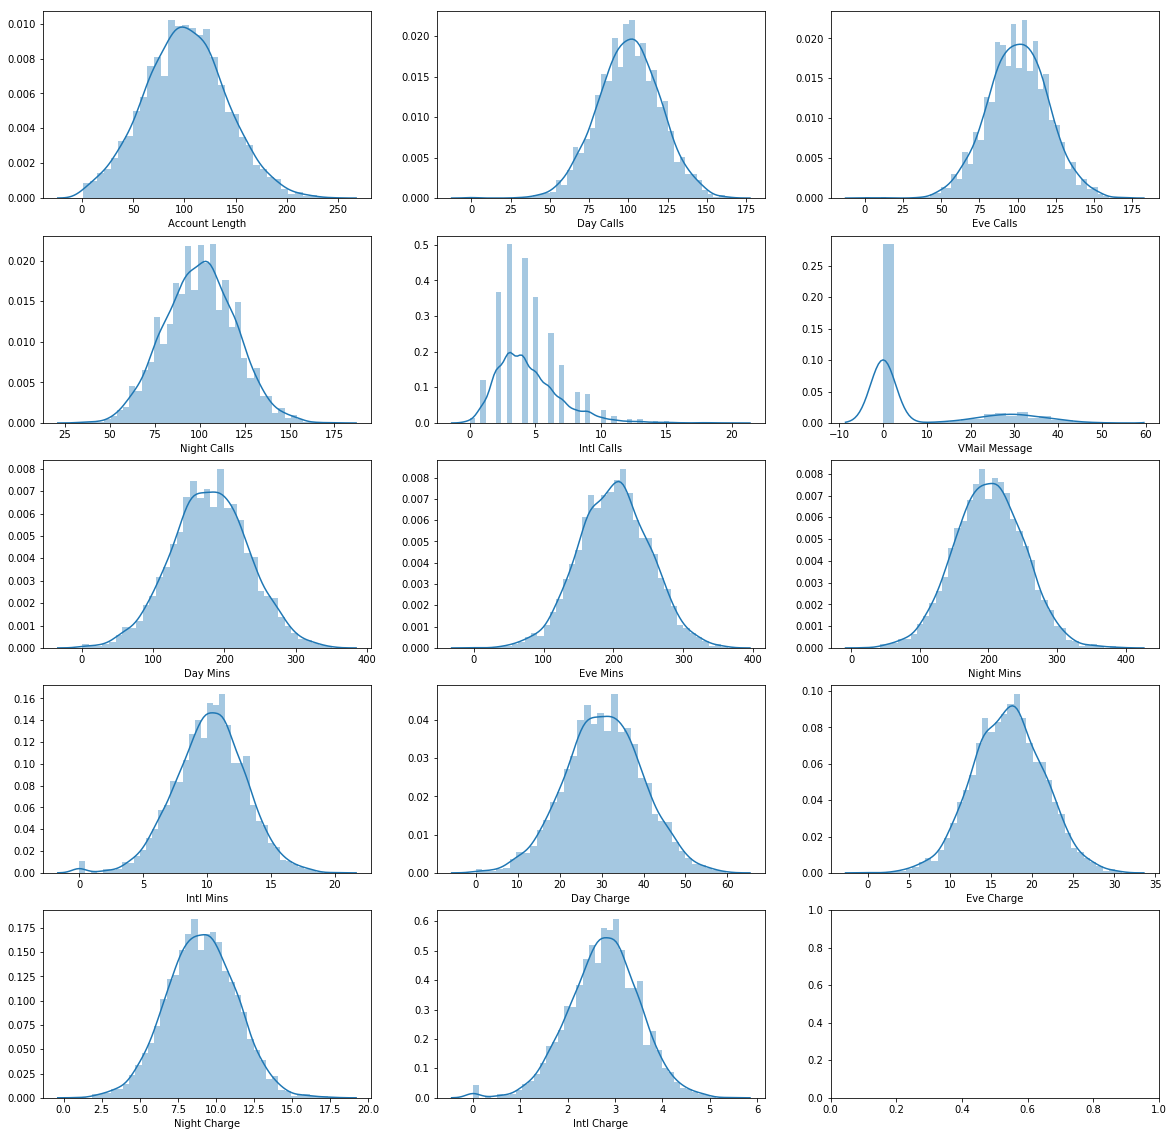

In [17]:
nums_ = ints_ + floats_ 
fig, ax = plt.subplots(nrows= int(np.ceil(len(nums_)/3)) , ncols = 3, figsize=(20,20))
i=0
for ax_ in ax:
    for ax__ in ax_:
        if i>=len(nums_):
            break
        sn.distplot(master_dataset[nums_[i]],ax=ax__)
        i=i+1

#### 3.1.2 Categorical

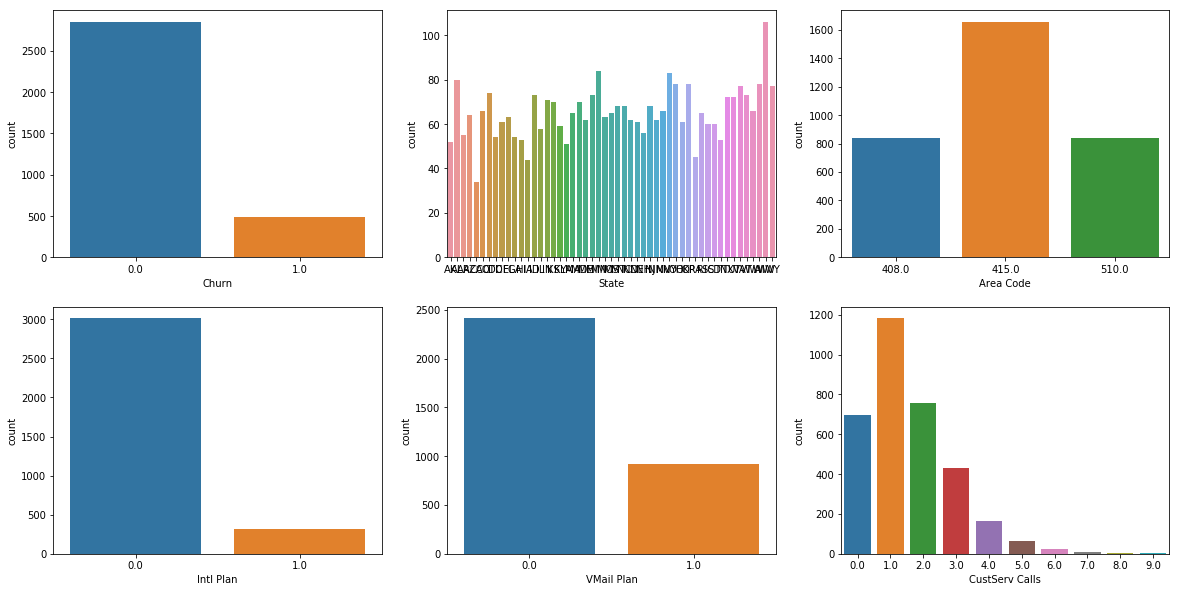

In [26]:
fig, ax = plt.subplots(nrows= int(np.ceil(len(categories_)/3)) , ncols = 3, figsize=(20,10))
i=0
for ax_ in ax:
    for ax__ in ax_:
        if i>=len(nums_):
            break
        sn.countplot(master_dataset[categories_[i]],ax=ax__)
        i=i+1

### 3.2 Bivariate Analysis

Let's visualize the data and distributions of combinations of variables. 

#### 3.2.1 Numerical vs Numerical

In [18]:
nums_

['Account Length',
 'Day Calls',
 'Eve Calls',
 'Night Calls',
 'Intl Calls',
 'VMail Message',
 'Day Mins',
 'Eve Mins',
 'Night Mins',
 'Intl Mins',
 'Day Charge',
 'Eve Charge',
 'Night Charge',
 'Intl Charge']

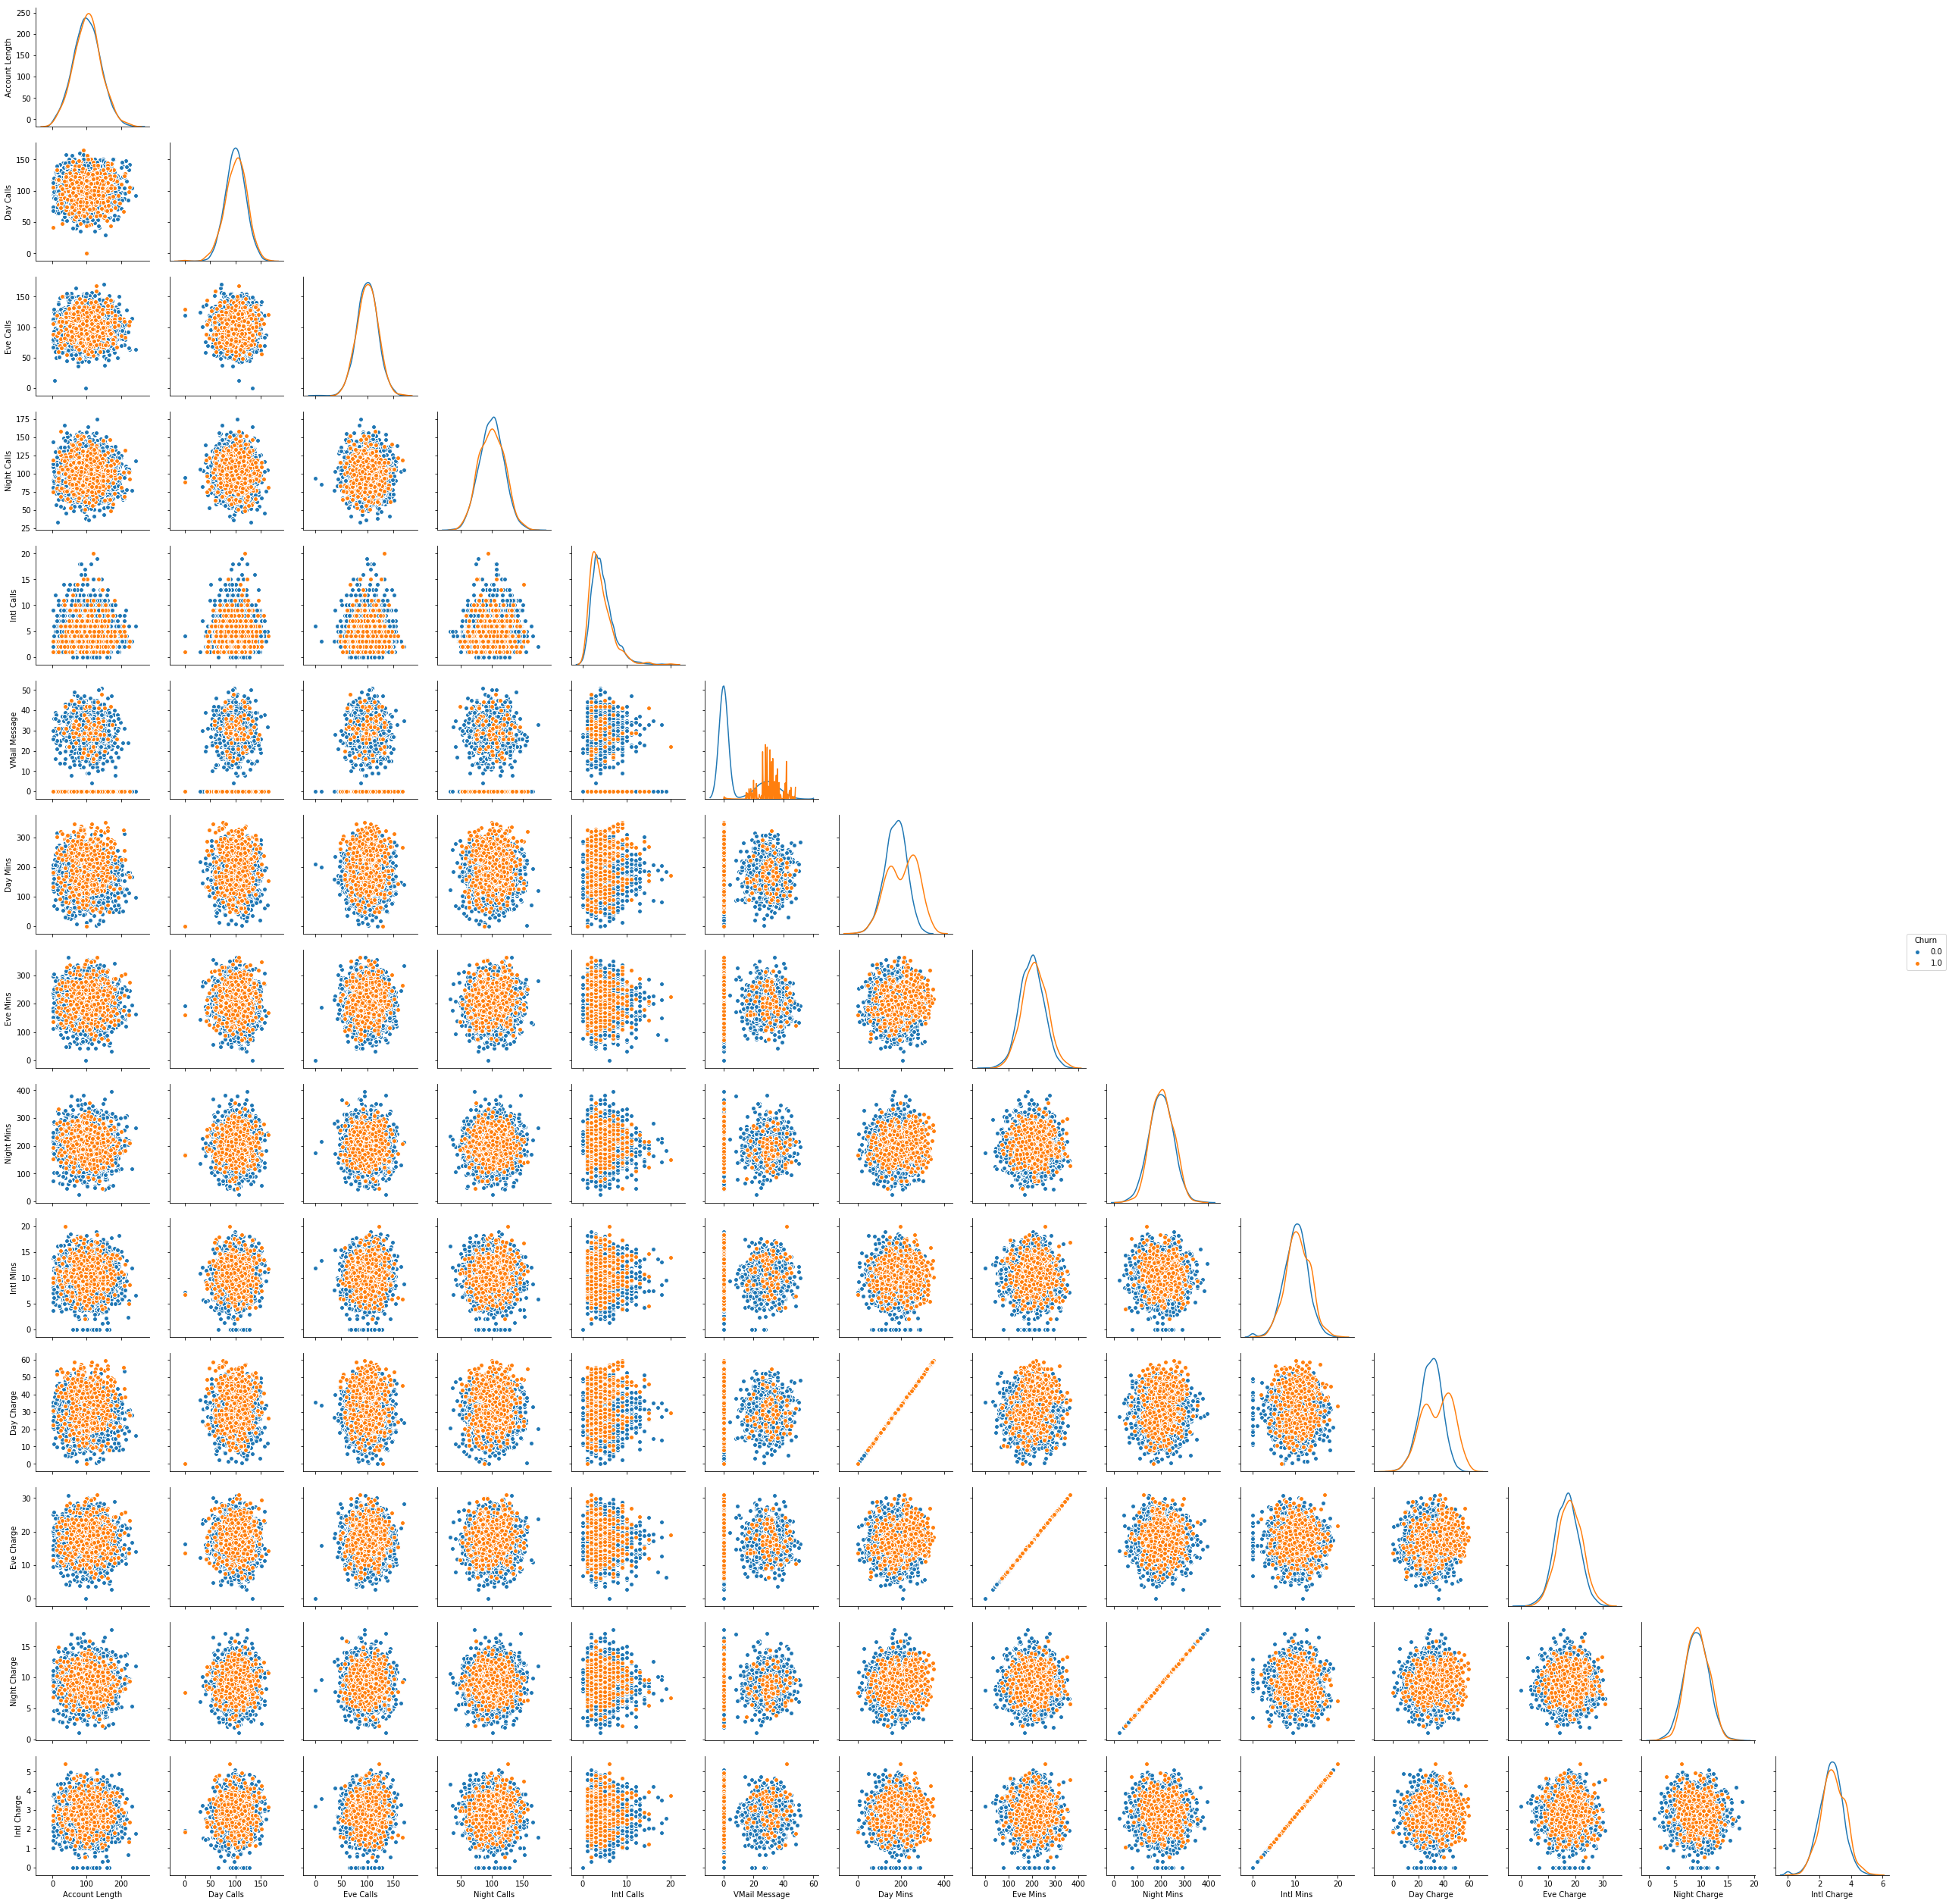

In [19]:
g=sn.pairplot(data=master_dataset,vars=nums_,hue='Churn',diag_kind='kde')
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)

#### 3.2.2 Categorical vs Categorical

In [28]:
categories_

['Churn', 'State', 'Area Code', 'Intl Plan', 'VMail Plan', 'CustServ Calls']

<b>Area code vs Churn </b><br>
Area Code 415 has 50% of ata points where as area codes 408 and 510 explain 50% of data together. Although, the churn rate in each of these areas lie between 150-200. Area code 408 and 510 have same amount of data and similar churn rates. 

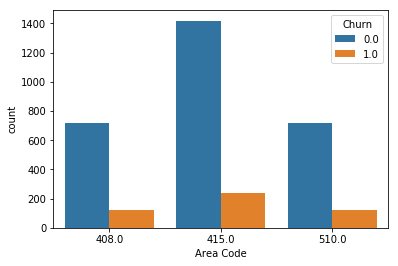

In [30]:
sn.countplot(x='Area Code',hue='Churn',data=master_dataset)

<b>Customer Service Class vs Churn </b><br>
As the customer service calls increase, Churn rate is likely to increase. Data points with customer service calls 9 have compltley churned. This means, increase in customer service calls likely result in customer churn. 

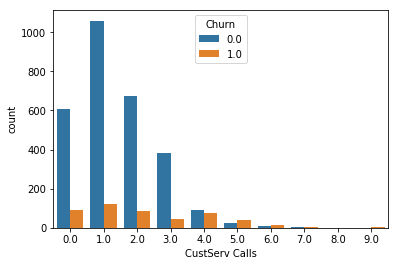

In [32]:
sn.countplot(x='CustServ Calls',hue='Churn',data=master_dataset)

<b>State vs Churn </b><br>

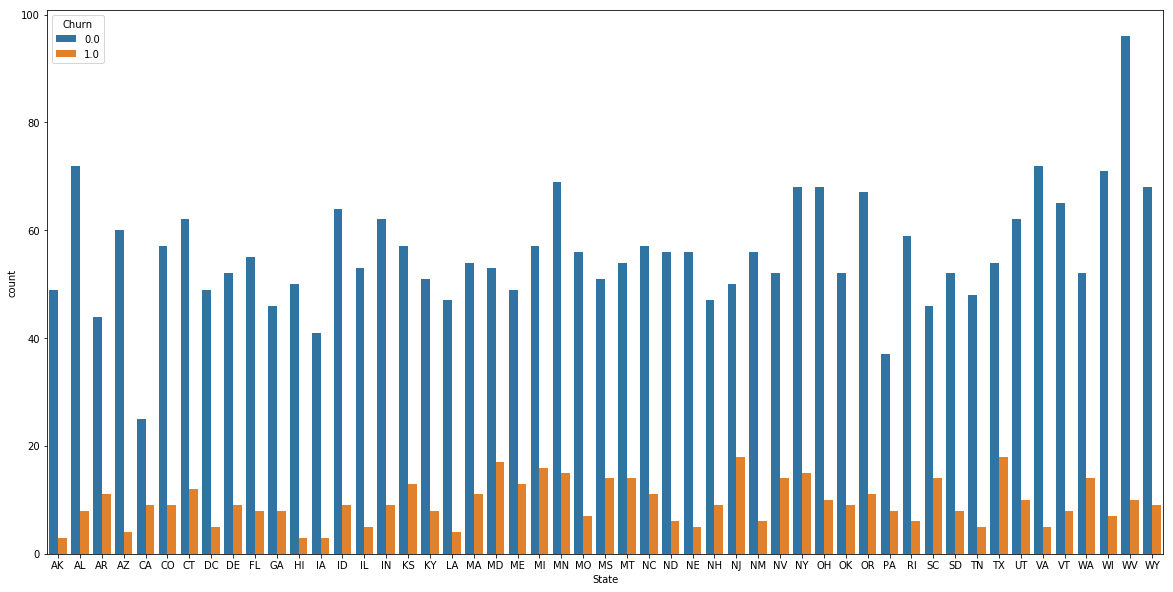

In [43]:
fig, ax = plt.subplots(nrows= 1 , ncols = 1, figsize=(20,10))
sn.countplot(x='State',hue='Churn',data=master_dataset,ax=ax)

<b>Intl Plan vs Churn </b><br>

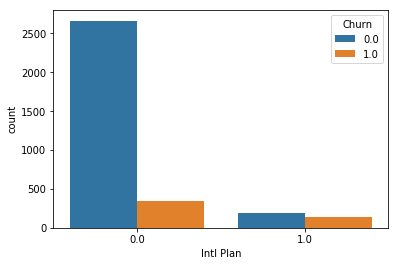

In [48]:
sn.countplot(x='Intl Plan',hue='Churn',data=master_dataset)

## 4. Outlier Treatment

## 5. Scaling

In [20]:
nums_ = ints_ + floats_ 
nums_zv = []
for column in nums_:
    nums_zv.append(column+"_zscore")
    mean_ = master_dataset[column].mean()
    std_ = master_dataset[column].std()
    master_dataset[column+"_zscore"] = (master_dataset[column]-mean_)/std_

In [21]:
master_dataset[nums_zv].head()

,Account Length_zscore,Day Calls_zscore,Eve Calls_zscore,Night Calls_zscore,Intl Calls_zscore,VMail Message_zscore,Day Mins_zscore,Eve Mins_zscore,Night Mins_zscore,Intl Mins_zscore,Day Charge_zscore,Eve Charge_zscore,Night Charge_zscore,Intl Charge_zscore
1,0.676388,0.476572,-0.055932,-0.465425,-0.601105,1.234697,1.566532,-0.070599,0.866613,-0.084995,1.566801,-0.070416,0.865899,-0.085678
3,0.149043,1.124334,0.144845,0.147802,-0.601105,1.307752,-0.333688,-0.108064,1.058412,1.240296,-0.333963,-0.107533,1.059231,1.240982
5,0.902393,0.675883,0.496204,0.198905,0.211502,-0.591671,1.168128,-1.573147,-0.756756,0.703015,1.168289,-1.573664,-0.755457,0.697052
7,-0.428526,-1.466716,-0.608068,-0.567629,1.024109,-0.591671,2.196267,-2.742453,-0.078539,-1.302831,2.196429,-2.742856,-0.078794,-1.306205
9,-0.654531,0.626055,1.098534,1.067643,-0.601105,-0.591671,-0.240054,-1.038776,-0.276270,-0.049177,-0.240005,-1.037784,-0.276520,-0.045878


## 6. Logistic Regression

## 8. Clustering

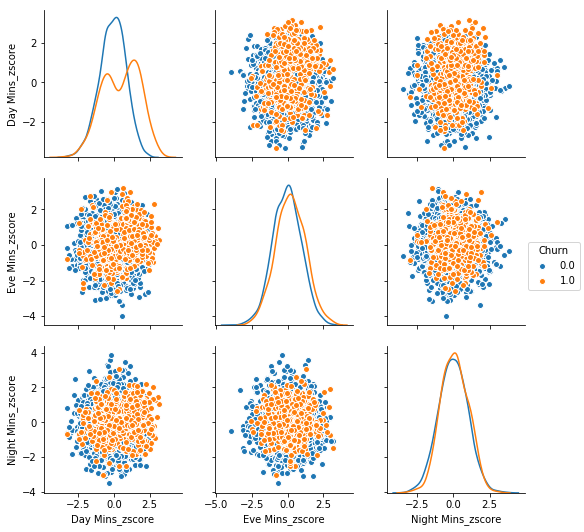

In [22]:
cluster_list_var = ['Day Mins_zscore','Eve Mins_zscore','Night Mins_zscore']
sn.pairplot(data=master_dataset,vars=cluster_list_var,hue='Churn',diag_kind='kde')

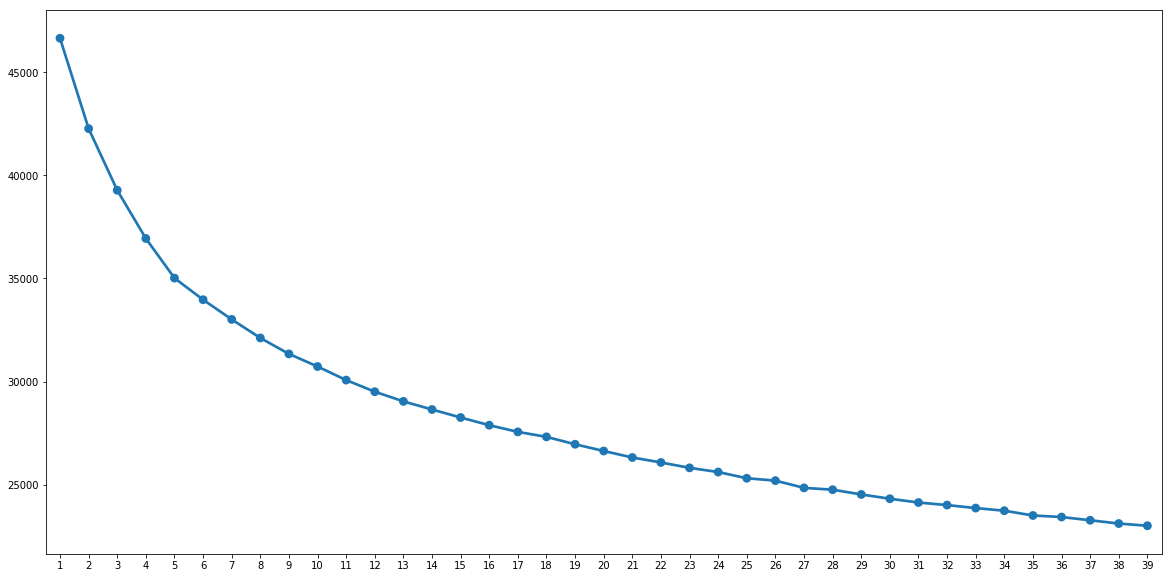

In [23]:
from sklearn.cluster import KMeans
cluster_ssd = []
cluster_index = []
X = master_dataset[nums_zv]
for i in range(1,40):
    kmeans = KMeans(n_clusters=i)
    kmeans = kmeans.fit(X)
    labels = kmeans.predict(X)
    cluster_ssd.append(kmeans.inertia_)
    cluster_index.append(i)
    centroids = kmeans.cluster_centers_
    
fig, ax = plt.subplots(nrows= 1, ncols = 1, figsize=(20,10))
sn.pointplot(y=cluster_ssd,x=cluster_index, ax=ax)
plt.show()